In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.float_format = "{:,.3f}".format

In [2]:
data = pd.read_csv('dataset-of-90s.csv')

Let's choose the nominal features. From features in data we'll get time signature in the track: it ranges from 1 to 5. To create other nominal features, let's modify data about duration and tempo:

(array([ 896.,    0.,    0.,    0.,    0., 1157.,    0.,    0.,    0.,
        3467.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

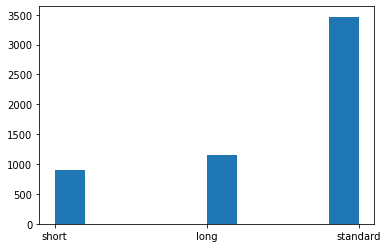

In [4]:
data['duration_s'] =data['duration_ms']/60000
data['duration_category'] = pd.cut(data['duration_s'], bins = [-1,3,5,np.inf], labels = ['short', 'standard', 'long'])
plt.hist(data['duration_category'])

Text(0.5, 0, 'Duration,minutes')

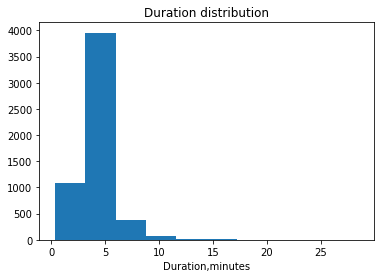

In [5]:
plt.hist(data['duration_s'])
plt.title('Duration distribution')
plt.xlabel('Duration,minutes')

Text(0.5, 0, 'Tempo, BPM')

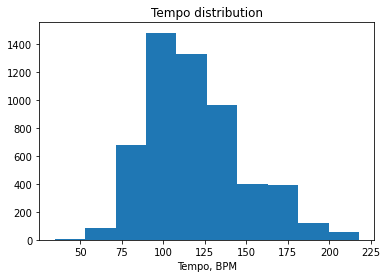

In [6]:
plt.hist(data['tempo'])
plt.title('Tempo distribution')
plt.xlabel('Tempo, BPM')

In [7]:
data['tempo_category'] = pd.cut(data['tempo'], bins = [0,76,108,120,156,176,np.inf], labels = [ 'adagio', 'andante', 'moderato', 
                                                                                                   'allegro', 'vivace', 'presto'])

In [8]:
pd.Series(data['time_signature'].value_counts()/ 5520)

4   0.912
3   0.072
5   0.011
1   0.005
Name: time_signature, dtype: float64

In [9]:
data['tempo_category'].value_counts()/ 5520

andante    0.377
allegro    0.312
moderato   0.151
vivace     0.075
presto     0.050
adagio     0.035
Name: tempo_category, dtype: float64

In [10]:
data['duration_category'].value_counts()/ 5520

standard   0.628
long       0.210
short      0.162
Name: duration_category, dtype: float64

In [34]:
def contingency_table(subset_1, subset_2):
    
    """
    An slower yet more intuitive way to create contingency table.
    returns contingency tables of two subsets,
    so that the last column and last row represent the
    marginal frequencies of Tk and Gl.
    """
    
    cat_1, cat_1_idx = np.unique(subset_1, return_inverse=True)
    cat_2, cat_2_idx = np.unique(subset_2, return_inverse=True)
    n_cat_1 = cat_1.shape[0]
    n_cat_2 = cat_2.shape[0]
    contingency = np.zeros([n_cat_1+1, n_cat_2+1], dtype=np.int)

    for row in range(n_cat_1):  
        for col in range(n_cat_2): 
            n_rc = len(set(np.where(cat_1_idx==row)[0].tolist()).intersection(
                    set(np.where(cat_2_idx==col)[0].tolist())))
            contingency[row, col] = n_rc
        contingency[row, -1] = np.sum(contingency[row, :])
    
    contingency[-1, :] = np.sum(contingency, axis=0)
    
    return contingency, cat_1, cat_2


def get_conditional(contingency, cat_1, cat_2):
    marginal_first =  contingency[-1, :-1].reshape(1,-1)
    conditional_frequencies = np.divide(contingency[:-1,:-1], marginal_first)
    cond_table  = pd.DataFrame( conditional_frequencies, index = cat_1, 
                               columns = cat_2)
    return cond_table


def get_quetelet(contingency, cat_1, cat_2):
    marginal_first =  contingency[-1, :-1].reshape(1,-1)
    conditional_frequencies = np.divide(contingency[:-1,:-1], marginal_first)
    marginal_second = contingency[:-1, -1].reshape(-1, 1) / 5520
    quetelet_index = np.subtract(np.divide(conditional_frequencies, marginal_second), 1)
    quetelet_index_table = pd.DataFrame(quetelet_index, index = cat_1, columns = cat_2)
    return quetelet_index_table

def get_average_quetlete(contingency,cat_1, cat_2):
    marginal_first =  contingency[-1, :-1].reshape(1,-1)
    marginal_second = contingency[:-1, -1].reshape(-1, 1)
    first_conditional = np.divide(contingency[:-1,:-1], marginal_first)
    second_conditional = np.divide(contingency[:-1,:-1], marginal_second)
    return pd.DataFrame(first_conditional * second_conditional, index = cat_1, columns = cat_2)

def get_average_quetlete_2(contingency,cat_1, cat_2):
    freq = contingency[:-1,:-1]/ contingency[-1,-1]
    return get_quetelet(contingency, cat_1, cat_2) * freq

In [12]:
time_tempo, cat_time, cat_tempo =contingency_table(data['time_signature'], data['tempo_category'])
dur_time, cat_dur, cat_time = contingency_table(data['duration_category'], data['time_signature'])
tempo_duration, cat_tempo, cat_dur = contingency_table(data['tempo_category'], data['duration_category'])

In [13]:
get_conditional(time_tempo, cat_time, cat_tempo)

,adagio,allegro,andante,moderato,presto,vivace
1,0.016,0.006,0.005,0.002,0.004,0.007
3,0.198,0.061,0.060,0.057,0.149,0.104
4,0.766,0.919,0.926,0.935,0.836,0.879
5,0.021,0.014,0.010,0.005,0.011,0.010


In [14]:
get_quetelet(time_tempo,  cat_time, cat_tempo)

,adagio,allegro,andante,moderato,presto,vivace
1,1.974,0.105,-0.086,-0.545,-0.308,0.383
3,1.731,-0.159,-0.171,-0.208,1.057,0.437
4,-0.160,0.008,0.015,0.026,-0.083,-0.036
5,0.949,0.304,-0.101,-0.552,0.021,-0.094


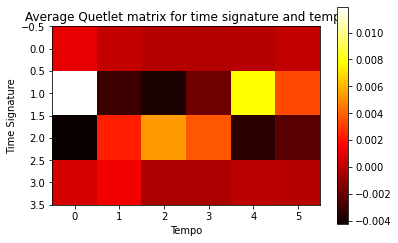

In [44]:
av_q_time_tempo = get_average_quetlete_2(time_tempo, cat_time, cat_tempo)
plt.imshow(av_q_time_tempo , cmap='hot', 
           interpolation='nearest')
plt.colorbar()
plt.xlabel('Tempo')
plt.ylabel('Time Signature')
plt.title('Average Quetlet matrix for time signature and tempo')
plt.show()

In [37]:
av_q_time_tempo.sum().sum()

0.018124298976288176

In [16]:
get_conditional(tempo_duration, cat_tempo, cat_dur)

,long,short,standard
adagio,0.054,0.042,0.027
allegro,0.315,0.304,0.313
andante,0.358,0.339,0.393
moderato,0.172,0.152,0.145
presto,0.036,0.071,0.049
vivace,0.065,0.092,0.074


In [46]:
get_quetelet(tempo_duration, cat_tempo, cat_dur)

,long,short,standard
adagio,0.541,0.219,-0.237
allegro,0.011,-0.027,0.003
andante,-0.051,-0.100,0.043
moderato,0.136,0.002,-0.046
presto,-0.271,0.434,-0.022
vivace,-0.134,0.223,-0.013


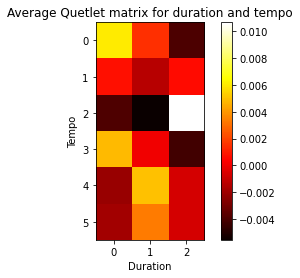

In [45]:
av_q_time_tempo = get_average_quetlete_2(tempo_duration, cat_tempo, cat_dur)
plt.imshow(av_q_time_tempo , cmap='hot', 
           interpolation='nearest')
plt.xlabel('Duration')
plt.ylabel('Tempo')
plt.title('Average Quetlet matrix for duration and tempo')
plt.colorbar()
plt.show()

In [40]:
av_q_time_tempo.sum().sum()

0.008925087985282909